<a href="https://www.kaggle.com/code/sukruthag/ecommerce-customer-churn-analysis-and-prediction?scriptVersionId=108925100" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install openpyxl
!pip install fancyimpute

  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.9/295.9 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.8 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29899 sha256=064807650e61005a5fdeb5814ad1fca1ea432c767912d4e48bc82a3b8f3f5409
  Stored in directory: /root/.cache/pip/wheels/e3/04/06/a1a7d89ef4e631ce6268ea2d8cde04f7290651c1ff1025ce68
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11353 sha256=a95b3195210358f8f0c1198f8a2181212b203ce6fb1e3885f112b871abe62361
  Stored in directory: /root/.cache/pip/wheels/72/21/a8/a045cacd9838abd5643f6bfa852c079

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from fancyimpute import IterativeImputer
from skopt import BayesSearchCV

import warnings
warnings.filterwarnings('ignore')

In [3]:
#read the data from the excel file
description = pd.read_excel('../input/ecommerce-customer-churn-analysis-and-prediction/E Commerce Dataset.xlsx', sheet_name='Data Dict', header=1, usecols=[1,2,3])
data = pd.read_excel('../input/ecommerce-customer-churn-analysis-and-prediction/E Commerce Dataset.xlsx', sheet_name='E Comm')
description

,Data,Variable,Discerption
0,E Comm,CustomerID,Unique customer ID
1,E Comm,Churn,Churn Flag
2,E Comm,Tenure,Tenure of customer in organization
3,E Comm,PreferredLoginDevice,Preferred login device of customer
4,E Comm,CityTier,City tier
5,E Comm,WarehouseToHome,Distance in between warehouse to home of customer
6,E Comm,PreferredPaymentMode,Preferred payment method of customer
7,E Comm,Gender,Gender of customer
8,E Comm,HourSpendOnApp,Number of hours spend on mobile application or...
9,E Comm,NumberOfDeviceRegistered,Total number of deceives is registered on part...


In [4]:
data.shape

(5630, 20)

In [5]:
data.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [6]:
data.dtypes

CustomerID                       int64
Churn                            int64
Tenure                         float64
PreferredLoginDevice            object
CityTier                         int64
WarehouseToHome                float64
PreferredPaymentMode            object
Gender                          object
HourSpendOnApp                 float64
NumberOfDeviceRegistered         int64
PreferedOrderCat                object
SatisfactionScore                int64
MaritalStatus                   object
NumberOfAddress                  int64
Complain                         int64
OrderAmountHikeFromlastYear    float64
CouponUsed                     float64
OrderCount                     float64
DaySinceLastOrder              float64
CashbackAmount                 float64
dtype: object

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

In [8]:
data.describe(include='all')

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5630.000000,5630.000000,5366.000000,5630,5630.000000,5379.000000,5630,5630,5375.000000,5630.000000,5630,5630.000000,5630,5630.000000,5630.000000,5365.000000,5374.000000,5372.000000,5323.000000,5630.000000
unique,NaN,NaN,NaN,3,NaN,NaN,7,2,NaN,NaN,6,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,Mobile Phone,NaN,NaN,Debit Card,Male,NaN,NaN,Laptop & Accessory,NaN,Married,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,2765,NaN,NaN,2314,3384,NaN,NaN,2050,NaN,2986,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,52815.500000,0.168384,10.189899,NaN,1.654707,15.639896,NaN,NaN,2.931535,3.688988,NaN,3.066785,NaN,4.214032,0.284902,15.707922,1.751023,3.008004,4.543491,177.223030
std,1625.385339,0.374240,8.557241,NaN,0.915389,8.531475,NaN,NaN,0.721926,1.023999,NaN,1.380194,NaN,2.583586,0.451408,3.675485,1.894621,2.939680,3.654433,49.207036
min,50001.000000,0.000000,0.000000,NaN,1.000000,5.000000,NaN,NaN,0.000000,1.000000,NaN,1.000000,NaN,1.000000,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000
25%,51408.250000,0.000000,2.000000,NaN,1.000000,9.000000,NaN,NaN,2.000000,3.000000,NaN,2.000000,NaN,2.000000,0.000000,13.000000,1.000000,1.000000,2.000000,145.770000
50%,52815.500000,0.000000,9.000000,NaN,1.000000,14.000000,NaN,NaN,3.000000,4.000000,NaN,3.000000,NaN,3.000000,0.000000,15.000000,1.000000,2.000000,3.000000,163.280000
75%,54222.750000,0.000000,16.000000,NaN,3.000000,20.000000,NaN,NaN,3.000000,4.000000,NaN,4.000000,NaN,6.000000,1.000000,18.000000,2.000000,3.000000,7.000000,196.392500


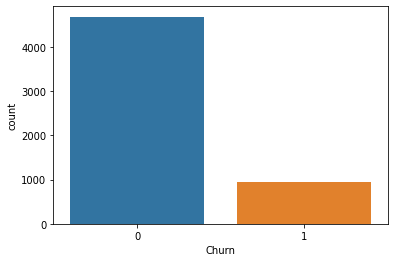

In [9]:
ax=sns.countplot(x='Churn', data = data)

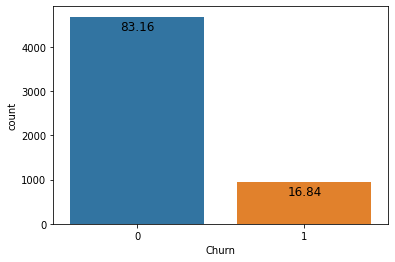

In [10]:
#counting the number of data is in churn class and not churn class
ax = sns.countplot(x='Churn', data = data)
for a in ax.patches:
    ax.annotate(format((a.get_height()/5630)*100,'.2f'), (a.get_x() + a.get_width()/2., a.get_height()),\
                ha='center',va='center',size=12,xytext=(0, -10),textcoords='offset points')
plt.show()

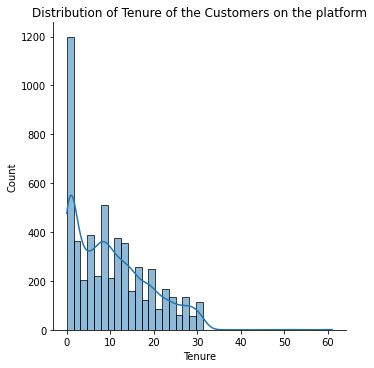

In [11]:
sns.displot(x='Tenure', kde=True, data=data)
plt.title("Distribution of Tenure of the Customers on the platform")
plt.show()

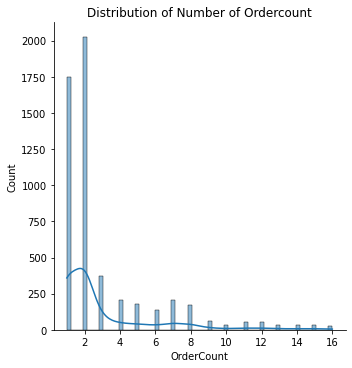

In [12]:
sns.displot(x='OrderCount', kde = True, data = data)
plt.title("Distribution of Number of Ordercount")
plt.show()

**Distribution of Recency of the Customers**

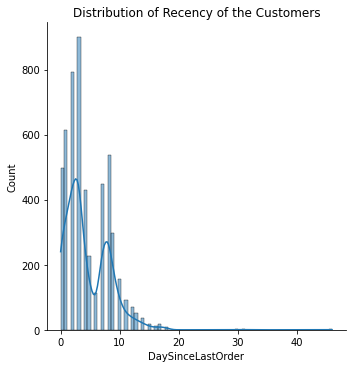

In [13]:
sns.displot(x='DaySinceLastOrder', kde = True, data = data)
plt.title("Distribution of Recency of the Customers")
plt.show()

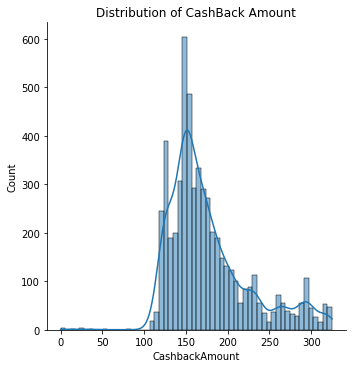

In [14]:
sns.displot(x='CashbackAmount', kde = True, data = data)
plt.title('Distribution of CashBack Amount')
plt.show()

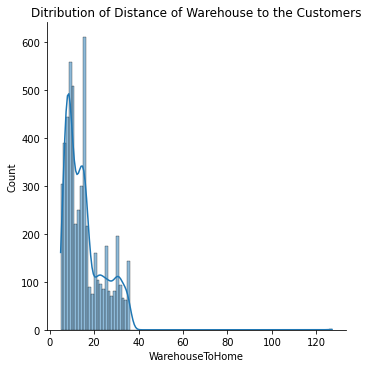

In [15]:
sns.displot(x='WarehouseToHome', kde = True, data = data)
plt.title("Ditribution of Distance of Warehouse to the Customers")
plt.show()

**Distribution of Percentage of Customer Increase In Orders**

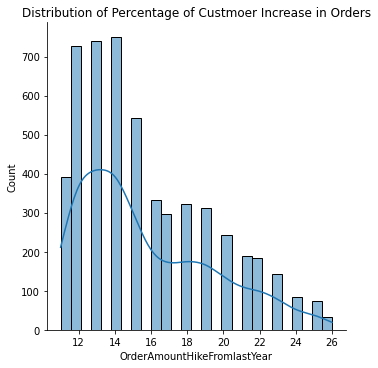

In [16]:
sns.displot(x='OrderAmountHikeFromlastYear', kde = True, data = data)
plt.title('Distribution of Percentage of Custmoer Increase in Orders')
plt.show()

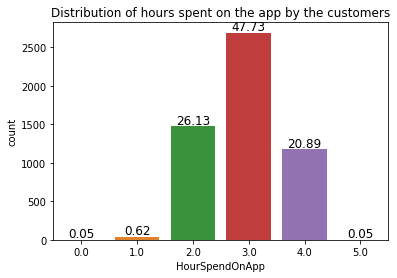

In [17]:
axx = sns.countplot(x='HourSpendOnApp', data=data)
for a in axx.patches:
    axx.annotate(format((a.get_height()/5630)*100,'.2f'), (a.get_x() + a.get_width()/2., a.get_height()),\
                ha='center',va='center',size=12,xytext=(0, 6),textcoords='offset points')
plt.title("Distribution of hours spent on the app by the customers")
plt.show()

**Distribution of Satisfaction score between Churned and Retained Customers**

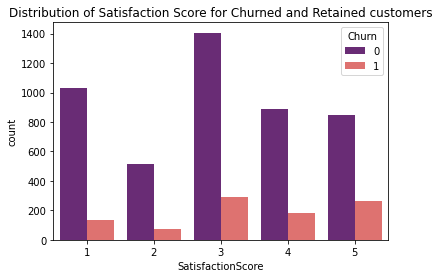

In [18]:
sns.countplot(x='SatisfactionScore', hue = 'Churn', palette ='magma', data = data )
plt.title("Distribution of Satisfaction Score for Churned and Retained customers")
plt.show()

"Distribution of Gender for Churned and Retained Customers

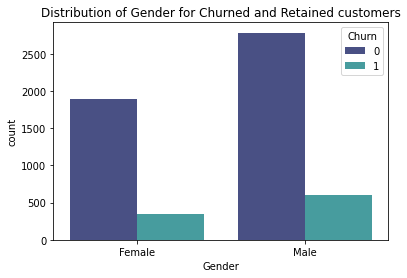

In [19]:
sns.countplot(x='Gender', hue = 'Churn', palette ='mako', data = data )
plt.title("Distribution of Gender for Churned and Retained customers")
plt.show()

**Distribution of Complain between Churn and Retained Customer**

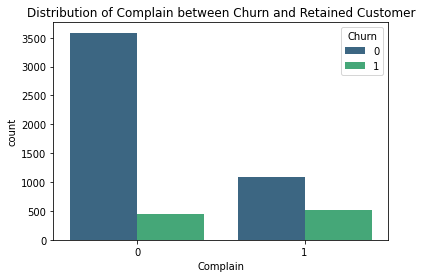

In [20]:
sns.countplot(x='Complain', hue = 'Churn', palette = 'viridis', data = data)
plt.title("Distribution of Complain between Churn and Retained Customer")
plt.show()

**Relationship between churn rate and order count**

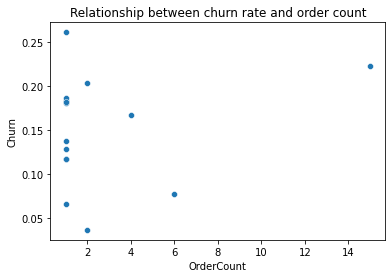

In [21]:
sns.scatterplot(x=data['OrderCount'], y = data.groupby('OrderCount').Churn.mean())
plt.title("Relationship between churn rate and order count")
plt.show()

**Relationship between Coupon used and Churn Rate**

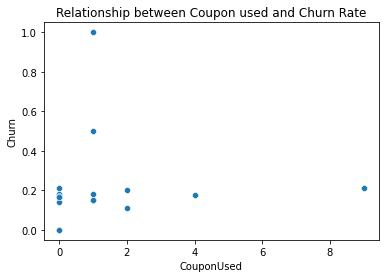

In [22]:
sns.scatterplot(x=data['CouponUsed'], y=data.groupby('CouponUsed').Churn.mean())
plt.title('Relationship between Coupon used and Churn Rate')
plt.show()

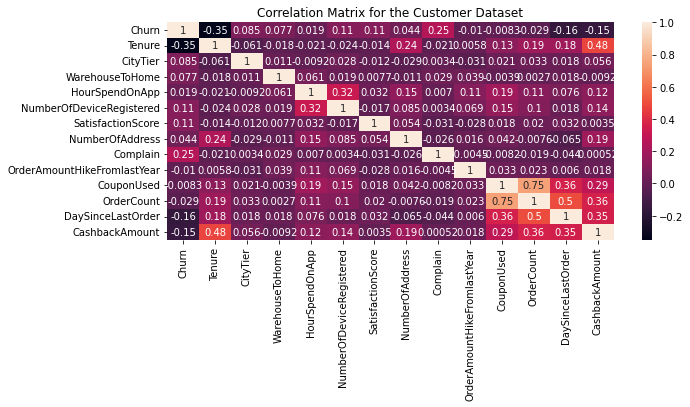

In [23]:
plt.figure(figsize = (10,4))
sns.heatmap(data.drop('CustomerID',axis=1).corr(), annot = True)
plt.title('Correlation Matrix for the Customer Dataset')
plt.show()

In [24]:
data.isnull().sum()

CustomerID                       0
Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64

In [25]:
print(f'The number of missing values: {data.isnull().sum().sum()}')

The number of missing values: 1856


In [26]:
data.describe()

,CustomerID,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5630.000000,5630.000000,5366.000000,5630.000000,5379.000000,5375.000000,5630.000000,5630.000000,5630.000000,5630.000000,5365.000000,5374.000000,5372.000000,5323.000000,5630.000000
mean,52815.500000,0.168384,10.189899,1.654707,15.639896,2.931535,3.688988,3.066785,4.214032,0.284902,15.707922,1.751023,3.008004,4.543491,177.223030
std,1625.385339,0.374240,8.557241,0.915389,8.531475,0.721926,1.023999,1.380194,2.583586,0.451408,3.675485,1.894621,2.939680,3.654433,49.207036
min,50001.000000,0.000000,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,1.000000,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000
25%,51408.250000,0.000000,2.000000,1.000000,9.000000,2.000000,3.000000,2.000000,2.000000,0.000000,13.000000,1.000000,1.000000,2.000000,145.770000
50%,52815.500000,0.000000,9.000000,1.000000,14.000000,3.000000,4.000000,3.000000,3.000000,0.000000,15.000000,1.000000,2.000000,3.000000,163.280000
75%,54222.750000,0.000000,16.000000,3.000000,20.000000,3.000000,4.000000,4.000000,6.000000,1.000000,18.000000,2.000000,3.000000,7.000000,196.392500
max,55630.000000,1.000000,61.000000,3.000000,127.000000,5.000000,6.000000,5.000000,22.000000,1.000000,26.000000,16.000000,16.000000,46.000000,324.990000


**Plot the missing values in all columns, using missingness matrix**

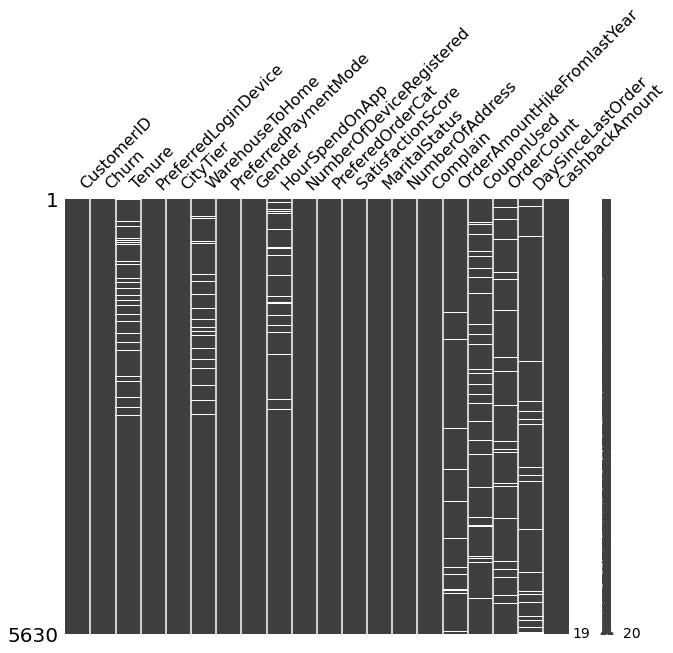

In [27]:
msno.matrix(data, figsize = (10,8))
plt.show()

**Plotting the sorted values in missingness matrix**

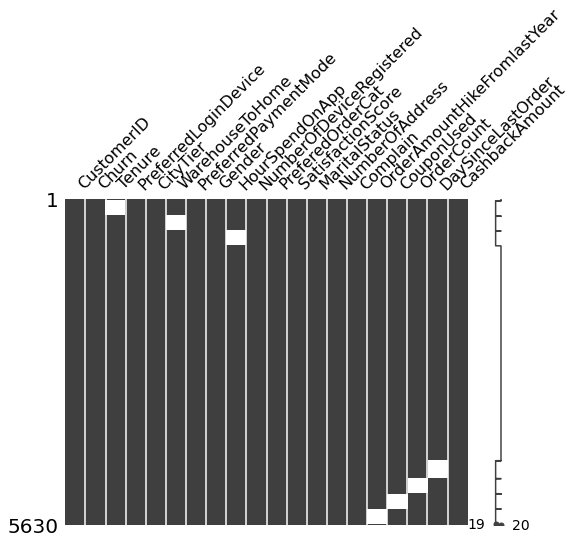

In [28]:
msno.matrix(data.sort_values(by='CashbackAmount'),figsize =(8,6))
plt.show()

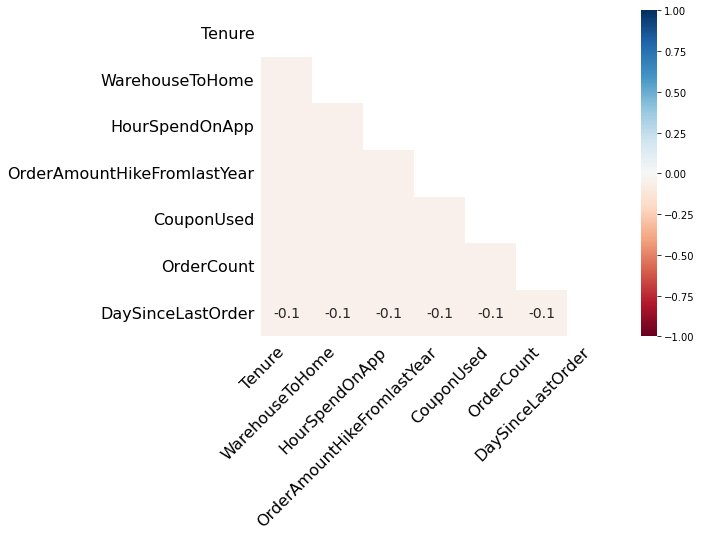

In [29]:
msno.heatmap(data, figsize=(8,6))
plt.show()

**Categorical Encoding** (Converting the categorical values to numerical values)

In [30]:
cat_data = data.select_dtypes(include = 'object')
cat_data


,PreferredLoginDevice,PreferredPaymentMode,Gender,PreferedOrderCat,MaritalStatus
0,Mobile Phone,Debit Card,Female,Laptop & Accessory,Single
1,Phone,UPI,Male,Mobile,Single
2,Phone,Debit Card,Male,Mobile,Single
3,Phone,Debit Card,Male,Laptop & Accessory,Single
4,Phone,CC,Male,Mobile,Single
...,...,...,...,...,...
5625,Computer,Credit Card,Male,Laptop & Accessory,Married
5626,Mobile Phone,Credit Card,Male,Fashion,Married
5627,Mobile Phone,Debit Card,Male,Laptop & Accessory,Married
5628,Computer,Credit Card,Male,Laptop & Accessory,Married


In [31]:
encoded = pd.get_dummies(cat_data, drop_first = True)

data_enc = pd.concat([data.drop(cat_data.columns,axis = 1),encoded], axis=1)
data_enc.drop('CustomerID', axis = 1, inplace = True)

**Model Development **

In [32]:
X = data_enc.drop(['Churn'],axis=1)
y = data_enc['Churn']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, stratify = y, random_state =0)

#Cross Validation
skfcv = StratifiedKFold(n_splits = 5)

**Logistic Regression**

In [33]:
#Build logistic regression pipeline
log_pipe = Pipeline([('imputer',IterativeImputer(random_state=0)),('scaler',StandardScaler()),
                    ('logreg',LogisticRegression())])

#cross validate logistic regression model
print(f"Cross validation score for Logistic Regression: {np.mean(cross_val_score(log_pipe, X_train, y_train, cv=skfcv, scoring='f1'))}")

Cross validation score for Logistic Regression: 0.6316720359392626


Using logistic regression pipeline to predict test samples

Test score for Logistic Regression: 0.6409495548961425
Training score for Logistic Regression: 0.6497305619707466


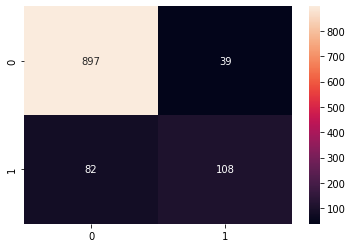

In [34]:
#use logistic regression pipeline to predict test sample
log_pipe.fit(X_train,y_train)
print(f"Test score for Logistic Regression: {f1_score(y_test, log_pipe.predict(X_test))}")
print(f"Training score for Logistic Regression: {f1_score(y_train, log_pipe.predict(X_train))}")
log_mat = confusion_matrix(y_test, log_pipe.predict(X_test))
sns.heatmap(log_mat, annot=True,fmt="g")
plt.show()

**Linear Discriminant Analysis**

In [35]:
#Build LinearDiscriminantAnalysis pipeline
lda_pipe = Pipeline([('imputer',IterativeImputer(random_state=0)),('scaler',StandardScaler()),
                    ('lda',LinearDiscriminantAnalysis())])

#cross validate LinearDiscriminantAnalysis model
print(f"Cross validation score for LinearDiscriminantAnalysis: {np.mean(cross_val_score(lda_pipe, X_train, y_train, cv=skfcv, scoring='f1'))}")

Cross validation score for LinearDiscriminantAnalysis: 0.5911106748453845


Test Score for LDA: 0.6358024691358025
Train Score for LDA: 0.6093874303898169


<function matplotlib.pyplot.show(close=None, block=None)>

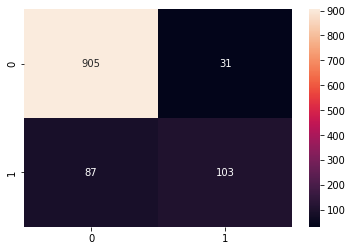

In [36]:
#using LDA pipeline to predict test sample
lda_pipe.fit(X_train, y_train)
print(f"Test Score for LDA: {f1_score(y_test, lda_pipe.predict(X_test))}")
print(f"Train Score for LDA: {f1_score(y_train, lda_pipe.predict(X_train))}")

lda_mat = confusion_matrix(y_test, lda_pipe.predict(X_test))
sns.heatmap(lda_mat, annot=True, fmt = "g")
plt.show

**Random Forest**

In [37]:
#building the random forest pipeline
rf_pipe = Pipeline([('imputer',IterativeImputer(random_state=0)),('scaler',StandardScaler()),
                   ('rfmodel',RandomForestClassifier())])
#cross validation
print(f"Cross Validation score for Random Forest: {np.mean(cross_val_score(rf_pipe, X_train, y_train,cv=skfcv, scoring='f1'))}")

Cross Validation score for Random Forest: 0.8490499957339512


Test score for Random Forest: 0.915068493150685
Training score for Random Forest: 1.0


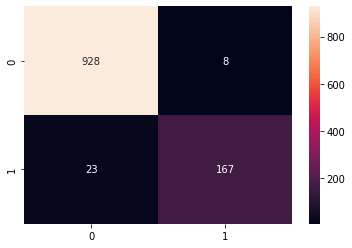

In [38]:
#using Random Forest pipeline to predict test sample
rf_pipe.fit(X_train,y_train)
print(f"Test score for Random Forest: {f1_score(y_test, rf_pipe.predict(X_test))}")
print(f"Training score for Random Forest: {f1_score(y_train, rf_pipe.predict(X_train))}")
rf_mat = confusion_matrix(y_test, rf_pipe.predict(X_test))
sns.heatmap(rf_mat, annot=True,fmt="g")
plt.show()

**XG Boost**

In [39]:
#XG Boost pipeline
xgb_pipe = Pipeline([('imputer',IterativeImputer(random_state=0)),('scaler',StandardScaler()),
                    ('xgb',XGBClassifier(verbosity=0,use_label_encoder=False))])

#cross validate XGBoost model
print(f"Cross validation score for XGBoost: {np.mean(cross_val_score(xgb_pipe, X_train, y_train, cv=skfcv, scoring='f1'))}")

Cross validation score for XGBoost: 0.8860940695783341


Test score for Random Forest: 0.9259259259259259
Training score for Random Forest: 1.0


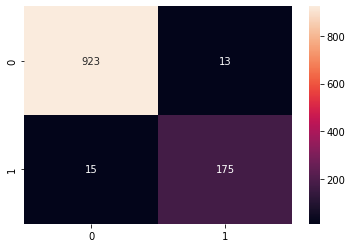

In [40]:
#using XG_Boost pipeline to predict sample
xgb_pipe.fit(X_train,y_train)
print(f"Test score for Random Forest: {f1_score(y_test, xgb_pipe.predict(X_test))}")
print(f"Training score for Random Forest: {f1_score(y_train, xgb_pipe.predict(X_train))}")
xgb_mat = confusion_matrix(y_test, xgb_pipe.predict(X_test))
sns.heatmap(xgb_mat, annot=True,fmt="g")
plt.show()


**Tuning the hyperparameters to reduce overfitting and improve test performance.**

In [41]:
#create hyperparameter search space
space={'xgb__eta': (0.01,0.3),
       'xgb__max_depth': (5,11),
      'xgb__subsample': (0.4,1),
      'xgb__n_estimators': (100,250),
      'xgb__gamma':(0,5),
      'xgb__colsample_bytree':(0.4,1),
      'xgb__min_child_weight': (0.3,1)}

In [42]:
#create BayesSearchCV object
search=BayesSearchCV(xgb_pipe,search_spaces=space,n_jobs=-1,cv=skfcv, scoring='f1')



In [43]:
#fit the object to the data
search.fit(X_train, y_train)

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=Pipeline(steps=[('imputer',
                                         IterativeImputer(random_state=0)),
                                        ('scaler', StandardScaler()),
                                        ('xgb',
                                         XGBClassifier(base_score=0.5,
                                                       booster='gbtree',
                                                       callbacks=None,
                                                       colsample_bylevel=1,
                                                       colsample_bynode=1,
                                                       colsample_bytree=1,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=Fa...
                                                       monotone_constr

In [44]:
#print the best cv score and the best parameters
print(search.best_score_)
print(search.best_params_)

0.9017856686180681
OrderedDict([('xgb__colsample_bytree', 0.7131336792012979), ('xgb__eta', 0.3), ('xgb__gamma', 0), ('xgb__max_depth', 11), ('xgb__min_child_weight', 0.3), ('xgb__n_estimators', 250), ('xgb__subsample', 1.0)])


0.9389920424403183


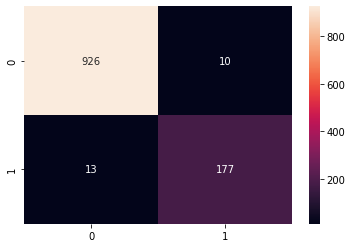

In [45]:
#use the best model parameters to predict the test sample and print the results
best_model=search.best_estimator_
print(f1_score(y_test,best_model.predict(X_test)))
sns.heatmap(confusion_matrix(y_test, best_model.predict(X_test)), annot=True, fmt="g")
plt.show()

**Conclusion**

After building the 4 models, the tree classifiers performed better than the linear classifiers, with XGBoost performing best with a test f1-score of 92.59%. I then tuned the xgboost hyperparameters which resulted in a 1.2% increase in cross validation score, and a 1.1% increase in test score.